<a href="https://colab.research.google.com/github/mario-ruoff/neural-network-learning/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Simple Convolutional Neural Network

#### Data Loader

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

# Downloading MNIST dataset
print("Loading dataset...")
train_data = datasets.MNIST(
    root="dataset",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = datasets.MNIST(
    root="dataset",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Hyperparameters
learning_rate = 0.05
batch_size = 32
epochs = 16

# Set data loader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
print("Done")

Loading dataset...
Done


NameError: name 'nvidia' is not defined

#### Network Setup

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


class MarioNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

Using cpu device


#### Network Training & Testing

MarioNet(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------


loss: 2.298893  [   32/60000]
loss: 2.292701  [ 3232/60000]
loss: 2.292983  [ 6432/60000]
loss: 2.263510  [ 9632/60000]
loss: 2.240956  [12832/60000]
loss: 2.231648  [16032/60000]
loss: 1.992696  [19232/60000]
loss: 1.287591  [22432/60000]
loss: 0.747202  [25632/60000]
loss: 0.749913  [28832/60000]
loss: 0.442388  [32032/60000]
loss: 0.213369  [35232/60000]
loss: 0.488692  [38432/60000]
loss: 0.284549  [41632/60000]
loss: 0.430131  [44832/60000]
loss: 0.327842  [48032/60000]
loss: 0.379046  [51232/60000]
loss: 0.369554  [54432/60000]
loss: 0.170186  [57632/60000]
Test Error: 
 Accuracy: 92.4%, Avg loss: 0.254451
Epoch 2
-------------------------------
loss: 0.426926  [   32/60000]
loss: 0.288100  [ 3232/60000]
loss: 0.226389  [ 6432/60000]
loss: 0.255553  [ 9632/60000]
loss: 0.108543  [12832/60000]
loss: 0.106137  [16032/60000]
loss: 0.082477  [19232/60000]
loss: 0.152714  [22432/60000]
loss: 0.182257  [25632/60000]
loss: 0.311325  [28832/60000]
loss: 0.147631  [32032/60000]
loss: 0.22

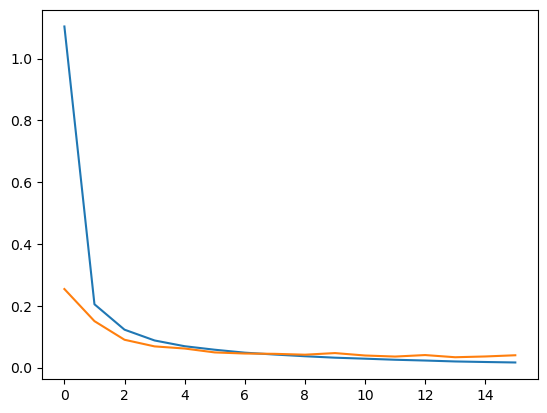

In [13]:
# Train loop
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print progress
        if batch % 100 == 0:
            current = batch * batch_size + len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{len(dataloader.dataset):>5d}]")

    return train_loss / len(dataloader)

# Test loop
def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            test_loss += loss_fn(logits, y).item()
            accuracy += (logits.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= len(dataloader)
    accuracy /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss

model = MarioNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(model)

train_losses = []
test_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_losses.append(train_loop(train_dataloader, model, loss_fn, optimizer))
    test_losses.append(test_loop(test_dataloader, model, loss_fn))

plt.plot(train_losses)
plt.plot(test_losses)
print("Done")

#### Analysis

In [14]:
index = 0


# pred_list = pred_probab.squeeze().tolist()
# y_pred = pred_probab.argmax(1)
# print(f"Predicted class: {y_pred.squeeze()}")
print("Label: ", labels[index], "- Prediction:", predictions[index].argmax(1))
plt.imshow(test_data.data[index].squeeze(), cmap=plt.cm.gray)
plt.show()
prediction = predictions[index].squeeze().tolist()
plt.bar(range(len(prediction)), prediction)

NameError: name 'labels' is not defined